In [3]:
#Connect to Opticstudio
import clr, os, winreg
from itertools import islice

#READ ME
#For the following to function, you MUST have your optics file open in Optic Studio, and
#you MUST go to "Programming" and then click on "Interactive Extension", then run the
#python program.

# determine the Zemax working directory
aKey = winreg.OpenKey(winreg.ConnectRegistry(None, winreg.HKEY_CURRENT_USER), r"Software\Zemax", 0, winreg.KEY_READ)
zemaxData = winreg.QueryValueEx(aKey, 'ZemaxRoot')
NetHelper = os.path.join(os.sep, zemaxData[0], r'ZOS-API\Libraries\ZOSAPI_NetHelper.dll')
winreg.CloseKey(aKey)

# add the NetHelper DLL for locating the OpticStudio install folder
clr.AddReference(NetHelper)
import ZOSAPI_NetHelper

pathToInstall = ''
# uncomment the following line to use a specific instance of the ZOS-API assemblies
#pathToInstall = r'C:\C:\Program Files\Zemax OpticStudio'

# connect to OpticStudio
success = ZOSAPI_NetHelper.ZOSAPI_Initializer.Initialize(pathToInstall)

zemaxDir = ''
if success:
    zemaxDir = ZOSAPI_NetHelper.ZOSAPI_Initializer.GetZemaxDirectory()
    print('Found OpticStudio at:   %s' + zemaxDir)
else:
    raise Exception('Cannot find OpticStudio')

# load the ZOS-API assemblies
clr.AddReference(os.path.join(os.sep, zemaxDir, r'ZOSAPI.dll'))
clr.AddReference(os.path.join(os.sep, zemaxDir, r'ZOSAPI_Interfaces.dll'))
import ZOSAPI

TheConnection = ZOSAPI.ZOSAPI_Connection()
if TheConnection is None:
    raise Exception("Unable to intialize NET connection to ZOSAPI")

TheApplication = TheConnection.ConnectAsExtension(0)
if TheApplication is None:
    raise Exception("Unable to acquire ZOSAPI application")

if TheApplication.IsValidLicenseForAPI == False:
    raise Exception("License is not valid for ZOSAPI use.  Make sure you have enabled 'Programming > Interactive Extension' from the OpticStudio GUI.")

TheSystem = TheApplication.PrimarySystem
if TheSystem is None:
    raise Exception("Unable to acquire Primary system")

print('Connected to OpticStudio')
####################################################################################################


#Program Setup
import numpy as np
import scipy
import scipy.io as scipyio
import sys
import matplotlib.pyplot as plt

def transpose(data):
    """Transposes a 2D list (Python3.x or greater).  
    
    Useful for converting mutli-dimensional line series (i.e. FFT PSF)
    
    Parameters
    ----------
    data      : Python native list (if using System.Data[,] object reshape first)    
    
    Returns
    -------
    res       : transposed 2D list
    """
    if type(data) is not list:
        data = list(data)
    return list(map(list, zip(*data)))
    
def reshape(data, x, y, transpose = False):
    """Converts a System.Double[,] to a 2D list for plotting or post processing
    
    Parameters
    ----------
    data      : System.Double[,] data directly from ZOS-API 
    x         : x width of new 2D list [use var.GetLength(0) for dimension]
    y         : y width of new 2D list [use var.GetLength(1) for dimension]
    transpose : transposes data; needed for some multi-dimensional line series data
    
    Returns
    -------
    res       : 2D list; can be directly used with Matplotlib or converted to
                a numpy array using numpy.asarray(res)
    """
    if type(data) is not list:
        data = list(data)
    var_lst = [y] * x;
    it = iter(data)
    res = [list(islice(it, i)) for i in var_lst]
    if transpose:
        return self.transpose(res);
    return res

##STAR Setup
analysis = TheSystem.Analyses
tools = TheSystem.Tools
surf_inds = [3,8,13,18,23,27,31,36,40,44]
surf_names = ['M1','M2','M3','LODM','Dicro','OAP1','OAP2','BMC','OAP3','OAP4']
n_surf = len(surf_inds)

#Field heights (1 is Default for on-axis)
hx = 1
hy = 1
nsteps = 4

# Get Surfaces
TheLDE = TheSystem.LDE
move_m2 = TheLDE.GetSurfaceAt(7)

#File IO setup
data_dir = 'c:\\Users\\locsst\\Desktop\\TD_picture_working\\ansys\\STAR\\'

Found OpticStudio at:   %sc:\program files\ansys zemax opticstudio 2022 r2.02
Connected to OpticStudio


Local Optimization...
Initial Merit Function  76.67170477137962
Intermediate Merit Function:  76.6268432502852
Hammering...
Final Merit Function:  8.24410723686014


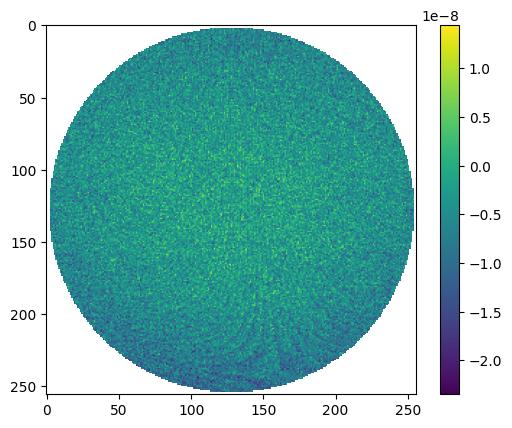

In [4]:
wf = TheSystem.Analyses.New_Analysis(ZOSAPI.Analysis.AnalysisIDM.WavefrontMap)

#for j in range(nsteps):

j = 0

#Clear Any Leftover STAR Data from previous runs
for i in range(n_surf):
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.UnloadData()

#Clear and set Variables for optimization, reset M2 Correction
tools.RemoveAllVariables()
move_m2.ThicknessCell.set_DoubleValue(0)
move_m2.GetCellAt(12).set_DoubleValue(0)
move_m2.GetCellAt(13).set_DoubleValue(0)
move_m2.GetCellAt(14).set_DoubleValue(0)
move_m2.GetCellAt(15).set_DoubleValue(0)

move_m2.ThicknessCell.MakeSolveVariable()
move_m2.GetCellAt(12).MakeSolveVariable()
move_m2.GetCellAt(13).MakeSolveVariable()
move_m2.GetCellAt(14).MakeSolveVariable()
move_m2.GetCellAt(15).MakeSolveVariable()

#Get data from nominal system
nominal_chief_arr = np.zeros((n_surf,2))

for i in range(n_surf):
    nominal_chief_arr[i,0] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[i],0,0,0,0,0,0,0)
    nominal_chief_arr[i,1] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[i],0,0,0,0,0,0,0)

#Open displacement data
for i in range(n_surf):
    disp_file = data_dir + "test_AM" + str(j+1) + surf_names[i] + ".txt"
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.FEAData.ImportDeformations(disp_file)
    #Set dz = 180 deg for nominal system alignment
    TheLDE.GetSurfaceAt(surf_inds[i]).STARData.Deformations.CoordinateTransform.SetTransformValuesWithAngles(0,0,180,0,0,0)

#Plot initial system error?


#Run optimizer (some set of change weights and running with various algorithms to get to a minimum?)
LocalOpt = TheSystem.Tools.OpenLocalOptimization()
if (LocalOpt != None):

    LocalOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.OrthogonalDescent
    LocalOpt.Cycles = ZOSAPI.Tools.Optimization.OptimizationCycles.Fixed_10_Cycles
    LocalOpt.NumberOfCores = 32
    print('Local Optimization...')
    print('Initial Merit Function ', LocalOpt.InitialMeritFunction)
    
    LocalOpt.RunAndWaitForCompletion()
    print('Intermediate Merit Function: ', LocalOpt.CurrentMeritFunction)
    LocalOpt.Close()

HammerOpt = tools.OpenHammerOptimization()
if (HammerOpt != None):
    
    HammerOpt.Algorithm = ZOSAPI.Tools.Optimization.OptimizationAlgorithm.DampedLeastSquares
    HammerOpt.NumberOfCores = 32
    print('Hammering...')

    HammerOpt.RunAndWaitWithTimeout(60)
    HammerOpt.Cancel()
    HammerOpt.WaitForCompletion()
    print('Final Merit Function: ', HammerOpt.CurrentMeritFunction)
    
    HammerOpt.Close()

wfresults = wf.GetResults()
wfgrid = wfresults.GetDataGrid(0).Values
wfarr = reshape(wfgrid,wfgrid.GetLength(0),wfgrid.GetLength(1))

plt.figure()
plt.imshow(wfarr)
plt.colorbar()
plt.show()

In [20]:
len(surf_inds)

12

In [21]:
type(wfgrid)

System.Double[,]

In [40]:
a = np.asarray(wfarr)
type(a[0,0])



numpy.float64

In [2]:
for j in range(4):
    print(j)

0
1
2
3


In [4]:
chief_arr = np.zeros((10,2))
for i in range(10):
    chief_arr[i-1,0] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAX, surf_inds[i-1],0,0,0,0,0,0,0)
    chief_arr[i-1,1] = TheSystem.MFE.GetOperandValue(ZOSAPI.Editors.MFE.MeritOperandType.REAY, surf_inds[i-1],0,0,0,0,0,0,0)

chief_arr

array([[ 0.00000000e+00,  1.60000000e+01],
       [ 2.08317793e-01, -3.30814336e+00],
       [ 1.41390753e+00,  1.99571703e-02],
       [-1.29996607e-02,  2.06068806e-02],
       [-1.44608322e-02,  2.11039973e-02],
       [ 2.91265565e+00,  2.13003484e-02],
       [-2.18727230e+00, -1.49185064e-02],
       [ 6.48788366e-02, -1.54154597e-02],
       [ 3.52167986e+00, -1.66155408e-02],
       [ 3.00951525e-03, -1.14246849e-03]])